## dump notebook for quick testing of modules

In [1]:
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path
from model.solver import Solver #bm3_barotropic_model packages
from model.sphere import Sphere
from model.forcing import Forcing

from utils import parcel_tracking as tracking


from utils import constants, plotting, config
import ensemble_methods as em

import time
import numpy as np
import random
import xarray as xr
import glob

import cartopy as crt             # Map projection stuff
import cartopy.crs as ccrs

import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    

from tqdm import tqdm

import json
from importlib import reload
from cython_routines import bm_methods as cbm

import glob

import seaborn as sns
import multiprocessing
import gc

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define your function to be parallelized
def worker_function(data_subset):
    return cbm.apply_find_bimodality(data_subset)

def parallel_process_data(ensemble, num_processes, save=False, save_str=None):
    if save and (save_str is None):
        raise ValueError("if saving, must provide a str for file name")
    for bb in range(0, ensemble.shape[0], num_processes):
        tst = time.time()                
        # Determine the actual number of processes to be used for the current chunk
        current_num_processes = min(num_processes, ensemble.shape[0] - bb)
        
        print(f'working on {bb}-{bb+current_num_processes} out of {ensemble.shape[0]}')

        pool = multiprocessing.Pool(processes=current_num_processes)

        
        # Create a subset of the ensemble for the current chunk
        print('time to load in :')
        data_brick = ensemble.isel(run=slice(bb, bb + current_num_processes)).values
        print('done loading')
        # Convert the subset to a list of data for each process
        data_chunks = [data_brick[i] for i in range(current_num_processes)]
        
        # Apply the worker function to each chunk in parallel
        results = pool.map(worker_function, data_chunks)
        pool.close()
        pool.join()
        
                # Extract results and deltas from multiprocessing output
        if bb==0:
            bm_results = [result[0] for result in results]
            deltas = [result[1] for result in results]
        else:
            bm_results.extend([result[0] for result in results])
            deltas.extend([result[1] for result in results])
        print('time for one loop,', time.time()-tst)
        del data_brick
        del data_chunks
        gc.collect()
        
        #print()
        
    
    print('done detecting..., converting to xarrays')
    
    bm_results = np.array(bm_results)
    deltas = np.array(deltas)

    
    # Get dimensions and coordinates from ensemble
    dims = [dim for dim in ensemble.dims if dim != 'ens_mem']
    coords = {dim: ensemble[dim].values for dim in dims}
    #print(coords)
    # Create xarray DataArrays with the same dimensions and coordinates as ensemble
    bm_results_xr = xr.DataArray(bm_results, dims=dims, coords=coords)
    deltas_xr = xr.DataArray(deltas, dims=dims, coords=coords)
    
    # Combine the DataArrays into a single Dataset
    combined_dataset = xr.Dataset({'bm_results': bm_results_xr, 'deltas': deltas_xr})
    if save:
        rpath = '/doppler/data8/bertossa/bm3/'
        combined_dataset.to_netcdf(rpath+save_str+'.nc')
    return combined_dataset

In [5]:
#from dask.distributed import Client

#client = Client(n_workers=4, threads_per_worker=2)
#client = Client()  # This doesn't work, and I don't know why
#ds = xr.open_mfdataset(fpaths, combine="nested", concat_dim="time", parallel=True)
def preprocess(ds):
    return ds.drop_vars(['params', 'v', 'u', 'thetap', 'vort', 'vortp'], errors='ignore')

ensemble = xr.open_mfdataset(
    '/doppler/data8/bertossa/bm3/LE_linear_seaice_run*.nc',
    concat_dim='run',
    combine='nested',
    parallel=True,
    data_vars=['theta'],
    preprocess=preprocess
)
print(ensemble)
ensemble_ss = ensemble.sel(y=slice(90,0)).sel(time=slice(1,15)).sel(ens_mem=slice(0,200)).theta
#ensemble_ss = ensemble.sel(y=slice(90,30)).sel(time=slice(1,40)).sel(ens_mem=slice(0,200)).theta

ensemble_ss = ensemble_ss.thin({'time':2})
#ensemble_ss = ensemble_ss[:,:,::2,:,:]
ensemble_ss


<xarray.Dataset>
Dimensions:  (time: 121, y: 64, x: 127, run: 80, ens_mem: 200)
Coordinates:
  * time     (time) float64 0.0 0.125 0.25 0.375 0.5 ... 14.62 14.75 14.88 15.0
  * y        (y) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * x        (x) float64 0.0 2.835 5.669 8.504 11.34 ... 348.7 351.5 354.3 357.2
Dimensions without coordinates: run, ens_mem
Data variables:
    theta    (run, ens_mem, time, y, x) float64 dask.array<chunksize=(1, 200, 121, 64, 127), meta=np.ndarray>


,Array,Chunk
Bytes,27.61 GiB,353.47 MiB
Shape,"(80, 200, 57, 32, 127)","(1, 200, 57, 32, 127)"
Count,560 Tasks,80 Chunks
Type,float64,numpy.ndarray


In [8]:
reload(em)

<module 'ensemble_methods' from '/home/bertossa/bm3/bm3_forced_barotropic/tests/../src/ensemble_methods.py'>

In [4]:
tst = time.time()
#nrun = 80
nprocess = 10
bm = parallel_process_data(ensemble_ss, num_processes=nprocess,
                           save=True, save_str ='bm_linear_seaice' )
print(f'time taken  using {nprocess} processes: ', time.time() - tst)

working on 0-10 out of 80
time to load in :
done loading
time for one loop, 553.3935980796814
working on 10-20 out of 80
time to load in :
done loading
time for one loop, 547.0573482513428
working on 20-30 out of 80
time to load in :
done loading
time for one loop, 540.4142215251923
working on 30-40 out of 80
time to load in :
done loading
time for one loop, 542.6129348278046
working on 40-50 out of 80
time to load in :
done loading
time for one loop, 550.1328327655792
working on 50-60 out of 80
time to load in :
done loading
time for one loop, 548.6045486927032
working on 60-70 out of 80
time to load in :
done loading
time for one loop, 541.6922433376312
working on 70-80 out of 80
time to load in :
done loading
time for one loop, 541.6298172473907
done detecting..., converting to xarrays
time taken  using 10 processes:  4371.430238485336


In [15]:
linear = 'nonlinear'
bmxr = xr.open_dataset(f'/doppler/data8/bertossa/bm3/bm_{linear}_seaice.nc')

In [68]:
bmxr=bmxr.rename({'y':'latitude'})

In [16]:
bm = bmxr.bm_results
deltas = bmxr.deltas

[11  3  7 90]


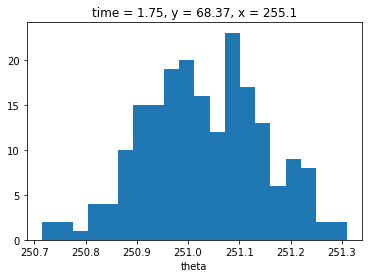

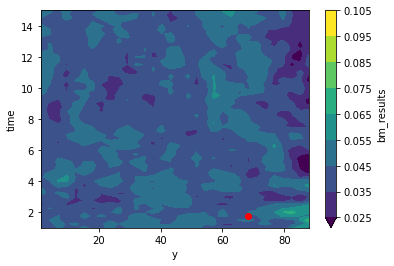

In [6]:

indices = np.argwhere( (bm.values==True))
random_index = indices[np.random.choice(indices.shape[0])]
print(random_index)
index_dict = {dim: idx for dim, idx in zip(bm.dims, random_index)}

# Convert the random_index to coordinate labels
coord_labels = {dim: ensemble_ss.coords[dim].isel({dim: idx}).item() for dim, idx in zip(bm.dims, random_index)}



selected_data = ensemble_ss.isel(index_dict)
selected_data.plot.hist(bins=20)
#[plt.axvline(i) for i in Ms.isel(index_dict).values]
plt.show()

hist2ddims = ['run','x']
bm.mean(hist2ddims).plot.contourf(levels = np.arange(0.025,0.115,0.01))

# Determine the remaining dimensions that weren't used in the mean calculation
remaining_dims = [dim for dim in bm.dims if dim not in hist2ddims]

# Add a scatter point using the remaining dimensions from bm.isel(index_dict)
plt.scatter(bm.isel(index_dict)[remaining_dims[1]], bm.isel(index_dict)[remaining_dims[0]], color='red')
#add scatter point onto the hist2ddims plot, where we use whatever two dimensions weren't on bm.mean() from bm.isel(index_dict)
plt.show()


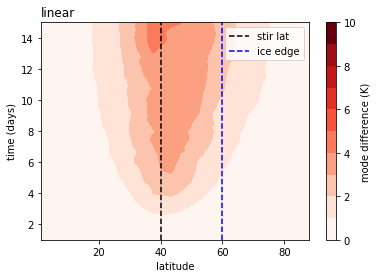

In [70]:
hist2ddims = ['run','x']
cb= deltas.mean(hist2ddims).plot.contourf(levels=np.arange(0,11,1), cmap='Reds', cbar_kwargs={'label':'mode difference (K)'})
plt.axvline(40, linestyle='--', color = 'k', label = 'stir lat')
plt.axvline(60, linestyle='--', color = 'b', label = 'ice edge')
plt.ylabel('time (days)')
plt.title(f'{linear}', loc='left')
plt.legend()
plt.savefig('./deltas.png',dpi=300)

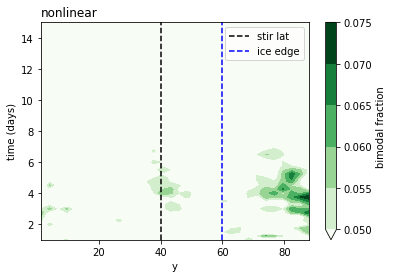

In [22]:
hist2ddims = ['run','x']
cb= bm.mean(hist2ddims).plot.contourf(levels=np.arange(0.05,0.08,0.005), cmap='Greens',vmin=0.5, cbar_kwargs={'label':'bimodal fraction'})
#cb.set_cbarlabel('')
plt.axvline(40, linestyle='--', color = 'k', label = 'stir lat')
plt.axvline(60, linestyle='--', color = 'b', label = 'ice edge')
plt.ylabel('time (days)')
plt.legend()
plt.title(f'{linear}', loc='left')
plt.legend()
plt.savefig('./bm.png',dpi=300)